In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import wooldridge

In [2]:

# =========================
# 1) Load intdef and build spread
# =========================
df = wooldridge.data('intdef')
df.index = pd.to_datetime(df['year'], format='%Y')

# define series: 3-month T-bill (i3) minus inflation (inf)
y_full = (df['i3'] - df['inf']).astype(float)
y = y_full.dropna()   # series used for estimation

In [3]:
# =========================
# 2) Linear AR(1)
# =========================
ar1 = AutoReg(y, lags=1, old_names=False).fit()
rss_lin = float(np.sum(ar1.resid**2))
print("\n=== Linear AR(1) ===")
print(ar1.summary())


=== Linear AR(1) ===
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   56
Model:                     AutoReg(1)   Log Likelihood                -111.067
Method:               Conditional MLE   S.D. of innovations              1.823
Date:                Tue, 19 Aug 2025   AIC                            228.135
Time:                        15:02:00   BIC                            234.157
Sample:                    01-01-1949   HQIC                           230.464
                         - 01-01-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6968      0.270      2.582      0.010       0.168       1.226
y.L1           0.4450      0.105      4.257      0.000       0.240       0.650
                              

C:\Users\daves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [4]:
# =========================
# 3) TAR(1) via grid search (branch-free updates)
# =========================
y_lag_full = y.shift(1)
mask = y_lag_full.notna()
y_t = y[mask]
y_lag = y_lag_full[mask]

qmin, qmax, grid = 0.10, 0.90, 120
low = float(y_lag.quantile(qmin))
high = float(y_lag.quantile(qmax))
taus = np.linspace(low, high, grid)

best_tau = taus[0]
best_rss = 1e300
best_c_hi = 0.0; best_phi_hi = 0.0; best_c_lo = 0.0; best_phi_lo = 0.0

min_n = int(np.ceil(max(8, 0.10 * len(y_t))))  # minimum obs per regime

for tau in taus:
    mask_hi = y_lag > tau
    mask_lo = ~mask_hi

    X_hi = sm.add_constant(y_lag[mask_hi])
    X_lo = sm.add_constant(y_lag[mask_lo])

    res_hi = sm.OLS(y_t[mask_hi], X_hi).fit()
    res_lo = sm.OLS(y_t[mask_lo], X_lo).fit()

    yhat = pd.Series(index=y_t.index, dtype=float)
    yhat[mask_hi] = res_hi.predict(X_hi)
    yhat[mask_lo] = res_lo.predict(X_lo)

    rss = float(np.nansum((y_t - yhat)**2))

    # penalize thresholds with too few obs in a regime
    too_small = (mask_hi.sum() < min_n) or (mask_lo.sum() < min_n)
    rss = rss + 1e12 * float(too_small)

    # branch-free update (take min)
    better = rss < best_rss
    b = float(better)
    best_tau    = best_tau*(1-b)   + tau*b
    best_rss    = best_rss*(1-b)   + rss*b
    best_c_hi   = best_c_hi*(1-b)  + float(res_hi.params.iloc[0])*b
    best_phi_hi = best_phi_hi*(1-b)+ float(res_hi.params.iloc[1])*b
    best_c_lo   = best_c_lo*(1-b)  + float(res_lo.params.iloc[0])*b
    best_phi_lo = best_phi_lo*(1-b)+ float(res_lo.params.iloc[1])*b

print("\n=== TAR(1) ===")
print(f"tau* = {best_tau:.6f}")
print(f"RSS(TAR) = {best_rss:.2f}   RSS(AR1) = {rss_lin:.2f}")
print(f"HI regime: y_t = {best_c_hi:.4f} + {best_phi_hi:.4f} y_(t-1)")
print(f"LO regime: y_t = {best_c_lo:.4f} + {best_phi_lo:.4f} y_(t-1)")

s_hi = best_c_hi/(1-best_phi_hi)
s_lo = best_c_lo/(1-best_phi_lo)
print(f"Long-run HI: {s_hi:.4f}   Long-run LO: {s_lo:.4f}")


=== TAR(1) ===
tau* = 0.855596
RSS(TAR) = 126.83   RSS(AR1) = 182.78
HI regime: y_t = -0.1865 + 0.9345 y_(t-1)
LO regime: y_t = -0.4971 + -0.1792 y_(t-1)
Long-run HI: -2.8457   Long-run LO: -0.4216


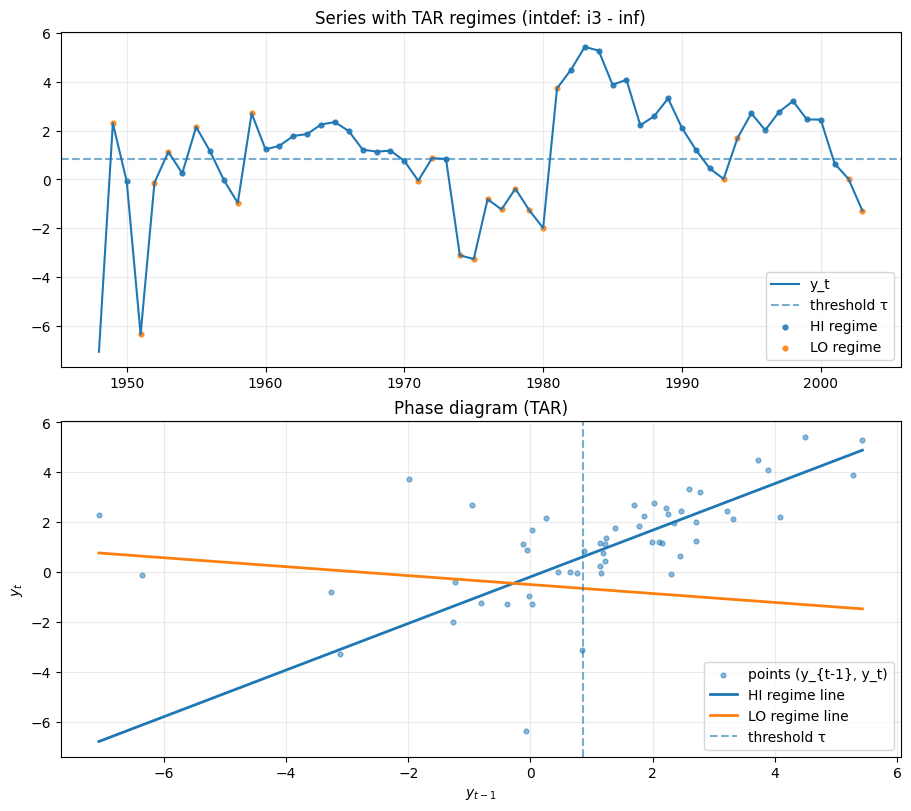


--- Diagnostics ---
RSS reduction TAR vs AR(1): 30.61%


In [5]:
# =========================
# 4) Plots
# =========================
fig, ax = plt.subplots(2, 1, figsize=(9, 8), constrained_layout=True)

# (a) time series with regimes
reg_hi = (y_lag > best_tau)
ax[0].plot(y_full.index, y_full.values, label='y_t')
ax[0].axhline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[0].scatter(y_t.index[reg_hi], y_t[reg_hi], s=12, alpha=0.85, label='HI regime')
ax[0].scatter(y_t.index[~reg_hi], y_t[~reg_hi], s=12, alpha=0.85, label='LO regime')
ax[0].set_title('Series with TAR regimes (intdef: i3 - inf)')
ax[0].legend()
ax[0].grid(alpha=0.25)

# (b) phase diagram
xgrid = np.linspace(float(y.min()), float(y.max()), 200)
line_hi = best_c_hi + best_phi_hi * xgrid
line_lo = best_c_lo + best_phi_lo * xgrid
ax[1].scatter(y_lag, y_t, s=12, alpha=0.5, label='points (y_{t-1}, y_t)')
ax[1].plot(xgrid, line_hi, lw=2, label='HI regime line')
ax[1].plot(xgrid, line_lo, lw=2, label='LO regime line')
ax[1].axvline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[1].set_xlabel('$y_{t-1}$')
ax[1].set_ylabel('$y_t$')
ax[1].set_title('Phase diagram (TAR)')
ax[1].legend()
ax[1].grid(alpha=0.25)

plt.show()

print("\n--- Diagnostics ---")
print(f"RSS reduction TAR vs AR(1): {(1 - best_rss/rss_lin)*100:.2f}%")

